In [1]:
import os, sys
import numpy as np
import json
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

## Preliminary

In [2]:
EPOCHS = 20
k = 5000 # number of samples used to calculate loss

In [3]:
torch.manual_seed(12345)
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
na_list = ['A', 'C', 'G', 'T'] #nucleic acids
aa_list = ['R', 'L', 'S', 'A', 'G', 'P', 'T', 'V', 'N', 'D', 'C', 'Q', 'E', 'H', 'I', 'K', 'M', 'F', 'W', 'Y'] #amino acids
hydrophobicity = {'G': 0, 'A': 41, 'L':97, 'M': 74, 'F':100, 'W':97, 'K':-23, 'Q':-10, 'E':-31, 'S':-5, 'P':-46, 'V':76, 'I':99, 'C':49, 'Y':63, 'H':8, 'R':-14, 'N':-28, 'D':-55, 'T':13}
NNK_freq = [0.09375]*3 + [0.0625]*5 + [0.03125]*13 #freq of 21 NNK codons including the stop codon
sum_20 = 0.0625*5 + 0.09375*3 + 0.03125*12 #sum of freq without the stop codon
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*12 #normalize freq for 20 codons
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11 + \
        [1- sum([0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11)] 
        #adjust sum to 1 due to numerical issue
aa_dict = dict(zip(aa_list, pvals))

## Dataset & Sampling

In [4]:
def construct_dataset():
    with open(aptamer_dataset_file, 'r') as f:
        aptamer_data = json.load(f)
    ds = []
    for aptamer in aptamer_data:
        peptides = aptamer_data[aptamer]
        if aptamer == "CTTTGTAATTGGTTCTGAGTTCCGTTGTGGGAGGAACATG": #took out aptamer control
            continue
        for peptide, _ in peptides:
            peptide = peptide.replace("_", "") #removed stop codons
            if "RRRRRR" in peptide: #took out peptide control
                continue
            if len(aptamer) == 40 and len(peptide) == 8: #making sure right length
                ds.append((aptamer, peptide))
    ds = list(set(ds)) #removed duplicates
    return ds

# Sample x from P_X (assume apatamers follow uniform)
def get_x():
    x_idx = np.random.randint(0, 4, 40)
    x = ""
    for i in x_idx:
        x += na_list[i]
    return x

# Sample y from P_y (assume peptides follow NNK)
def get_y():
    y_idx = np.random.choice(20, 7, p=pvals)
    y = "M"
    for i in y_idx:
        y += aa_list[i]
    return y

# S'(train/test) contains S_train/S_test with double the size of S_train/S_test
def get_S_prime(kind="train"):
    if kind == "train":
        dset = S_train
    else:
        dset = S_test
    k = len(dset)
    S_prime_dict = dict.fromkeys(dset, 0) #indicator 0 means in S
    for _ in range(k):
        pair = (get_x(), get_y())
        S_prime_dict[pair] = 1 #indicator 1 means not in S
    S_prime = [[k,int(v)] for k,v in S_prime_dict.items()] 
    np.random.shuffle(S_prime)
    return S_prime

# S new contains unseen new examples
def get_S_new(k):
    S_new = []
    for i in range(k):
        pair = (get_x(), get_y())
        S_new.append(pair)
    np.random.shuffle(S_new)
    return S_new
    
# Returns pmf of an aptamer
def get_x_pmf():
    return 0.25**40

# Returns pmf of a peptide
def get_y_pmf(y):
    pmf = 1
    for char in y[1:]: #skips first char "M"
        pmf *= aa_dict[char]
    return pmf    

In [5]:
aptamer_dataset_file = "../data/aptamer_dataset.json"
S = construct_dataset()
n = len(S)
m = int(0.8*n) #length of S_train
S_train = S[:m]
S_test = S[m:]
S_prime_train = get_S_prime("train") #use for sgd 
S_prime_test = get_S_prime("test") #use for sgd 
S_new = get_S_new(10*n) #use for eval
train_ds = np.hstack((S_train, S_prime_train[:len(S_prime_train)//2]))

## NN Model

In [6]:
class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        self.cnn_apt_1 = nn.Conv2d(1, 120, (4,4)) #similar to 4-gram
        self.cnn_apt_2 = nn.Conv2d(120, 50, 1)
        self.cnn_apt_3 = nn.Conv2d(50, 10, 1)
        
        self.cnn_pep_1 = nn.Conv2d(1, 50, (4,20))
        self.cnn_pep_2 = nn.Conv2d(50, 10, 1)
        
        self.relu = nn.ReLU()
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.relu, self.cnn_apt_2, self.relu)
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.relu, self.cnn_pep_2, self.relu)
        
        
        self.fc1 = nn.Linear(1900, 1)
        self.name = "SimpleConvNet"
        
    def forward(self, apt, pep):
        apt = self.cnn_apt(apt)
        apt = self.relu(apt)
        pep = self.cnn_pep(pep)
        pep = self.relu(pep)
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.zeros_(m.bias.data)
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='sigmoid')
        nn.init.zeros_(m.bias.data)

In [7]:
class MoreComplexNet(nn.Module):
    def __init__(self):
        super(MoreComplexNet, self).__init__()
        self.cnn_apt_1 = nn.Conv2d(1, 500, 1) 
        self.cnn_apt_2 = nn.Conv2d(500, 1000, 1)
        self.cnn_apt_3 = nn.Conv2d(1000, 500, 2)
        self.cnn_apt_4 = nn.Conv2d(500, 100, 2)
        self.cnn_apt_5 = nn.Conv2d(100, 10, 2)
        
        self.cnn_pep_1 = nn.Conv2d(1, 250, 1)
        self.cnn_pep_2 = nn.Conv2d(250, 500, 1)
        self.cnn_pep_3 = nn.Conv2d(500, 250, 3)
        self.cnn_pep_4 = nn.Conv2d(250, 100, 2)
        self.cnn_pep_5 = nn.Conv2d(100, 10, 2)
        
        self.relu = nn.ReLU()
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.relu, self.cnn_apt_2, self.relu, self.cnn_apt_3, self.relu, self.cnn_apt_4, self.relu, self.cnn_apt_5)
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.relu, self.cnn_pep_2, self.relu, self.cnn_pep_3, self.relu, self.cnn_pep_4, self.relu, self.cnn_pep_5)
        
        self.name = "MoreComplexNet"
        self.fc1 = nn.Linear(1010, 1)
    
    def forward(self, apt, pep):
        apt = self.cnn_apt(apt)
        apt = self.relu(apt)
        pep = self.cnn_pep(pep)
        pep = self.relu(pep)
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

In [9]:
class Conv1dModel(nn.Module):
    def __init__(self):
        super(NLPModel, self).__init__()
        self.cnn_apt_1 = nn.Conv1d(40, 500, 3) 
        self.cnn_apt_2 = nn.Conv1d(500, 1000, 3)
        self.cnn_apt_3 = nn.Conv1d(1000, 500, 3)
        self.cnn_apt_4 = nn.Conv1d(500, 100, 3)
        self.cnn_apt_5 = nn.Conv1d(100, 10, 3)
        
        self.cnn_pep_1 = nn.Conv1d(8, 250, 3)
        self.cnn_pep_2 = nn.Conv1d(250, 500, 3)
        self.cnn_pep_3 = nn.Conv1d(500, 250, 3)
        self.cnn_pep_4 = nn.Conv1d(250, 100, 3)
        self.cnn_pep_5 = nn.Conv1d(100, 10, 3)
        
        self.relu = nn.ReLU()
        self.name = "Conv1Model"
        self.maxpool = nn.MaxPool1d(2) 
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.maxpool, self.relu, self.cnn_apt_2, self.maxpool, self.relu, self.cnn_apt_3, self.maxpool, self.relu, self.cnn_apt_4, self.maxpool, self.relu, self.cnn_apt_5, self.relu)
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.maxpool, self.relu, self.cnn_pep_2, self.maxpool, self.relu, self.cnn_pep_3, self.maxpool, self.relu, self.cnn_pep_4, self.maxpool, self.relu, self.cnn_pep_5, self.relu)
        
        
        self.fc1 = nn.Linear(180, 1)
    
    def forward(self, apt, pep):
        apt = self.cnn_apt(apt)
        apt = self.relu(apt)
        pep = self.cnn_pep(pep)
        pep = self.relu(pep)
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

In [ ]:
class Conv1dModelSimple(nn.Module):
    def __init__(self):
        super(NLPModel, self).__init__()
        self.cnn_apt_1 = nn.Conv1d(40, 100, 3) 
        self.cnn_apt_2 = nn.Conv1d(100, 150, 3)
        self.cnn_apt_3 = nn.Conv1d(150, 100, 3)

        
        self.cnn_pep_1 = nn.Conv1d(8, 50, 3)
        self.cnn_pep_2 = nn.Conv1d(50, 25, 3)
        self.cnn_pep_3 = nn.Conv1d(25, 10, 3)

        
        self.relu = nn.ReLU()
        self.name = "Conv1ModelSimple"
        self.maxpool = nn.MaxPool1d(2) 
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.maxpool, self.relu, self.cnn_apt_2, self.maxpool, self.relu, self.cnn_apt_3, self.relu)
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.maxpool, self.relu, self.cnn_pep_2, self.maxpool, self.relu, self.cnn_pep_3, self.relu)
        
        self.fc1 = nn.Linear(180, 1)
    
    def forward(self, apt, pep):
        apt = self.cnn_apt(apt)
        apt = self.relu(apt)
        pep = self.cnn_pep(pep)
        pep = self.relu(pep)
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

## Helper methods

In [8]:
## Takes a peptide and aptamer sequence and converts to one-hot matrix
def one_hot(sequence, seq_type='peptide'):
    if seq_type == 'peptide':
        letters = aa_list
    else:
        letters = na_list
    one_hot = np.zeros((len(sequence), len(letters)))
    for i in range(len(sequence)):
        char = sequence[i]
        for _ in range(len(letters)):
            idx = letters.index(char)
            one_hot[i][idx] = 1
    return one_hot

# Convert a pair to one-hot tensor
def convert(apt, pep, conv_type='2d'): 
    apt = one_hot(apt, seq_type='aptamer') #(40, 4)
    pep = one_hot(pep, seq_type='peptide') #(8, 20)
    if conv_type == '2d':
        apt = torch.FloatTensor(np.reshape(apt, (1, 1, apt.shape[0], apt.shape[1]))).cuda() #(1, 1, 40, 4)
        pep = torch.FloatTensor(np.reshape(pep, (1, 1, pep.shape[0], pep.shape[1]))).cuda() #(1, 1, 8, 20)
    else:
        apt = torch.FloatTensor(np.reshape(apt, (1, apt.shape[0], apt.shape[1]))).cuda() #(1, 40, 4)
        pep = torch.FloatTensor(np.reshape(pep, (1, pep.shape[0], pep.shape[1]))).cuda() #(1, 8, 20)
    return apt, pep

# Getting the output of the model for a pair (aptamer, peptide)
def update(x, y):
    x.requires_grad=True
    y.requires_grad=True
    x = x.cuda()
    y = y.cuda()
    out = model(x, y)
    return out

# Generates the samples used to calculate loss
def loss_samples(k, ds='train', conv_type='2d'): # S_train/S_test
    if ds == 'train':
        dset = S_train
    else:
        dset = S_test
    pairs = []
    for (apt, pep) in dset[:k]:
        x, y = convert(apt, pep, conv_type=conv_type)
        pairs.append((x, y))
    return pairs

# Generates the samples used to calculate loss from S_prime_train/S_prime_test
def prime_loss_samples(k, ds='train', conv_type='2d'): # S_prime_train/S_prime_test
    if ds == "train":
        dset = S_prime_train[len(S_prime_train)//2:]    
    else:
        dset = S_prime_test[len(S_prime_test)//2:]
    pairs = []
    for (apt, pep), ind in dset[:k]:
        pmf = get_y_pmf(pep)
        x, y = convert(apt, pep, conv_type=conv_type)
        pairs.append((x, y, ind, pmf))
    return pairs

# First term of the loss
def get_log_out(dataset='train'):
    outs = []
    if dataset == 'train':
        dset = train_loss_samples
    else:
        dset = test_loss_samples
    for (apt, pep) in dset:
        out = update(apt, pep)
        outs.append(torch.log(out).cpu().detach().numpy().flatten()[0])
    return np.average(outs)

# Second term of loss
def get_out_prime(ds="train"):
    outs = []
    if ds == "train":
        dset = prime_train_loss_samples
        leng = m
    else:
        dset = prime_test_loss_samples
        leng = n-m
    for (apt, pep, ind, pmf) in dset:
        x = apt.cuda()
        y = pep.cuda()
        out = model(x, y)
        if ind == 0:
            factor = (2*leng*get_x_pmf()*pmf)/(1+leng*get_x_pmf()*pmf)
        else:
            factor = 2
        out_is = out.cpu().detach().numpy().flatten()[0] * factor
        outs.append(out_is)
    return np.average(outs)

## Plotting functions

def plot_loss(train_loss, test_loss, i, j, lamb, gamma):
    plt.plot(train_loss, 'b', label='Train loss')
    plt.plot(test_loss, 'y', label='Test loss')
    plt.ylabel("Loss")
    plt.xlabel("Number of iterations")
    plt.title('Loss after ' +  str(i) + " iterations, " + str(j) + " epochs, " + 'lambda =%.5f' % lamb  + ' gamma =%.5f' % gamma)
    plt.legend()
    plt.show()

def plot_recall(train_recall, test_recall, new_recall, i, j, lamb, gamma):
    plt.plot(train_recall, 'b', label='Train recall')
    plt.plot(test_recall, 'y', label='Test recall')
    plt.plot(new_recall, 'r', label='New recall')
    plt.ylabel("Recall (%)")
    plt.xlabel("Number of iterations")
    plt.title('Recall after ' + str(i) + " iterations, " + str(j) + " epochs, " + 'lambda =%.5f' % lamb  + ' gamma =%.5f' % gamma)
    plt.legend()
    plt.show()
    
def plot_cdf(train_cdf, test_cdf, i, j, lamb, gamma):
    plt.plot(train_cdf, 'b', label='Train CDF')
    plt.plot(test_cdf, 'y', label='Test CDF')
    plt.ylabel("CDF")
    plt.xlabel("Most recent 10,000 samples")
    plt.title('CDF after ' + str(i) + " iterations, " + str(j) + " epochs, " + 'lambda =%.5f' % lamb  + ' gamma =%.5f' % gamma)
    plt.legend()
    plt.show()

def histogram(eval_scores, train_scores, test_scores):
    f, axes = plt.subplots(2, 2, figsize=(7, 7), sharex=True)
    plt.xlim(0, 1.1)
    sns.distplot(eval_scores , color="skyblue", label='New: not in dataset', ax=axes[0, 0])
    sns.distplot(train_scores , color="gold", label='Train: in dataset', ax=axes[1, 0])
    sns.distplot(test_scores, color='red', label='Test: in the dataset', ax=axes[0, 1])
    axes[0,0].set_title("New: not in dataset")
    axes[1,0].set_title("Train: in dataset")
    axes[0, 1].set_title("Test: in dataset")
    plt.show()

## SGD

In [10]:
def sgd(model_name, lamb=1e28, #hyperparam
        gamma=1e-3, #step size
        save_checkpoints=False): #save checkpoints
    
    optim = SGD(model.parameters(), lr=gamma)
    model.to(device)
    epoch = 0
    
    if 'Conv1' in model_name:
        conv_type = '1d'
    while epoch < EPOCHS:
        train_losses = []
        train_recalls = []
        train_recall_outputs = [] 

        test_losses = []
        test_recalls = []
        test_recall_outputs = []

        new_outputs = []
        new_recalls = []

        train_correct = 0
        test_correct = 0
        new_correct = 0
        
        for i, (aptamer, peptide, (apt_prime, pep_prime), indicator) in enumerate(tqdm.tqdm(train_ds)):
            if i == 0:
                continue
            model.train()
            optim.zero_grad() 
            x, y = convert(aptamer, peptide, conv_type=conv_type) #sample x,y from S_train
            out = update(x, y) #get S_train output/score
            log_out = torch.log(out) 
            
            train_score = out.cpu().detach().numpy().flatten()[0] 
            if train_score > 0.6:
                train_correct += 1 
            train_recall_outputs.append(train_score) 

            optim.zero_grad() 
            y_pmf = get_y_pmf(pep_prime)
            x_prime, y_prime = convert(apt_prime, pep_prime, conv_type=conv_type) #sample x', y' from S_prime_train
            out_prime = update(x_prime, y_prime) #get score from S_prime_train
            if indicator == 0:
                factor = (2*m*get_x_pmf()*y_pmf)/(1+m*get_x_pmf()*y_pmf)
            else:
                factor = 2
            out_prime = out_prime*factor #adjust for IS
            #print("Obj first part: ", out_prime.cpu().detach().numpy().flatten()[0]*lamb*indicator)
            #print("Obj second part: ", log_out.cpu().detach().numpy().flatten()[0])
            # Retain graph retains the graph for further operations
            (lamb*indicator*out_prime - log_out).backward(retain_graph=True) 
            optim.step()

            with torch.no_grad():
                model.eval()
            
            x_test, y_test = convert(S_test[i%(n-m)][0], S_test[i%(n-m)][1], conv_type=conv_type) #sample x,y from test set
            test_score = model(x_test, y_test).cpu().detach().numpy().flatten()[0]
            test_recall_outputs.append(test_score) 
            if test_score > 0.6:
                test_correct += 1 

            #generate 10 unseen examples from S_new as compared 1 example from S_train/S_test for cdfs
            for x, y in S_new[10*i:10*(i+1)]:
                x_new, y_new = convert(x, y, conv_type=conv_type) #generate unseen x'' and y'' from S_new
                new_score = model(x_new, y_new).cpu().detach().numpy().flatten()[0] #get unknown score
                new_outputs.append(new_score)
                if new_score < 0.3:
                    new_correct += 1

            if i % 10000 == 0:
                train_loss = lamb*get_out_prime("train") - get_log_out('train') #training loss
                #print("Train loss first part: ", lamb*get_out_prime("train"))
                #print("Train loss second part: ", get_log_out('train'))
                test_loss = (m/(n-m))*lamb*get_out_prime("test") - get_log_out('test') #test loss
                #print("Test loss first part: ", lamb*get_out_prime("test"))
                #print("Test loss second part: ", get_log_out('test'))
                train_losses.append(train_loss)
                test_losses.append(test_loss)

                train_recall = 100*train_correct/i #training recall
                train_recalls.append(train_recall) 
                test_recall = 100*test_correct/i #test recall
                test_recalls.append(test_recall)
                new_recall = 100*new_correct/(i*10) #generated dataset recall
                new_recalls.append(new_recall)
                if i > 1000:
                    train_score = np.asarray(new_outputs[-10000:] + train_recall_outputs[-1000:]) 
                    test_score = np.asarray(new_outputs[-10000:] + test_recall_outputs[-1000:])
                else:
                    train_score = np.asarray(new_outputs + train_recall_outputs) #combine train and unknown scores
                    test_score = np.asarray(new_outputs + test_recall_outputs) #combibne test and unknown scores
                train_cdf = np.cumsum(train_score)/np.sum(train_score) #train cdf
                test_cdf = np.cumsum(test_score)/np.sum(test_score) #test cdf


            if i % 100000 == 0:
                plot_recall(train_recalls, test_recalls, new_recalls, i, epoch, lamb, gamma)
                plot_loss(train_losses, test_losses, i, epoch, lamb, gamma)
                plot_cdf(train_cdf, test_cdf, i, epoch, lamb, gamma)
                histogram(new_outputs[-1000:], train_recall_outputs[-1000:], test_recall_outputs[-1000:])
                print("New score: ", np.average(new_outputs[-50:]))
                print("Train score: ", np.average(train_score[-50:]))
                print("Test score: ", np.average(test_score[-50:]))
        # Save after every epoch
        if save_checkpoints:
            checkpoint_name = '../models/model_checkpoints/' + str(model_name) + '_lambda=' + str(lamb) + '_gamma=' + str(gamma) + '.pth'
            torch.save({'epoch': epoch,'model_state_dict': model.state_dict(), 'optimizer_state_dict': optim.state_dict()}, checkpoint_name)
            

## Hyperparameter tuning

In [11]:
# Hyperparameter search
gammas = [1e-3, 1e-2]
lambdas = [5, 10, 2]

Lambda: 5 Gamma: 0.001


 21%|██        | 100000/473047 [1:18:40<4:51:15, 21.35it/s]  

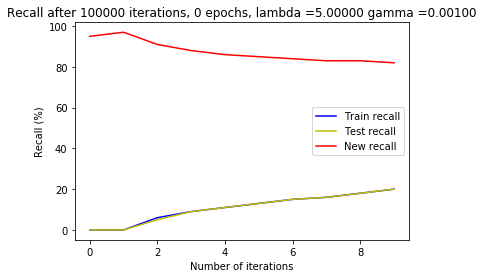

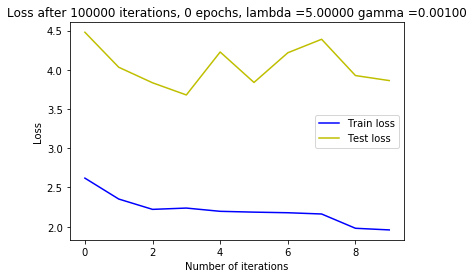

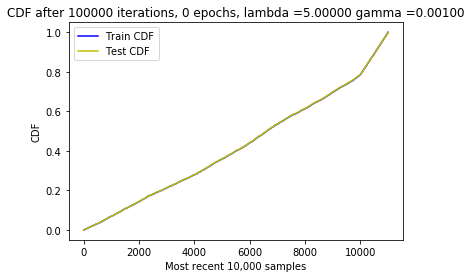

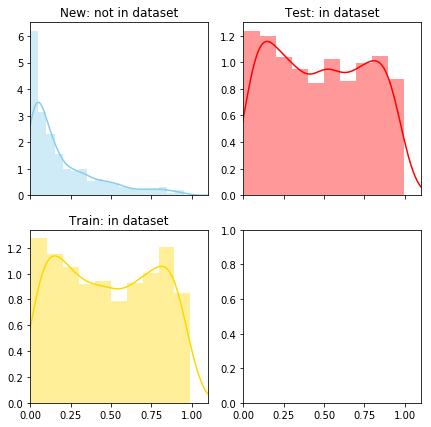

 21%|██        | 100004/473047 [1:19:01<829:26:51,  8.00s/it] 

('New score: ', 0.24995074)
('Train score: ', 0.5085713)
('Test score: ', 0.54098064)


 42%|████▏     | 200000/473047 [2:38:00<3:31:04, 21.56it/s]   

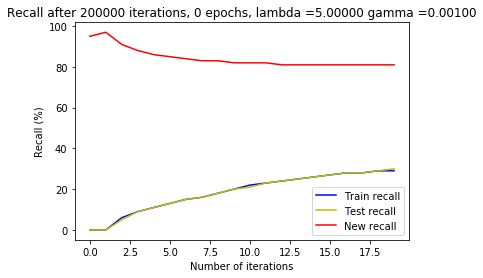

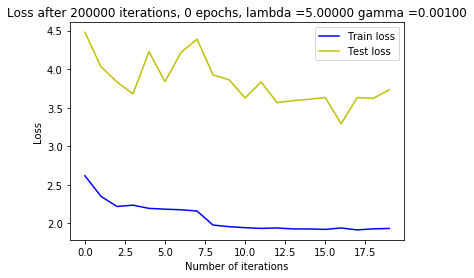

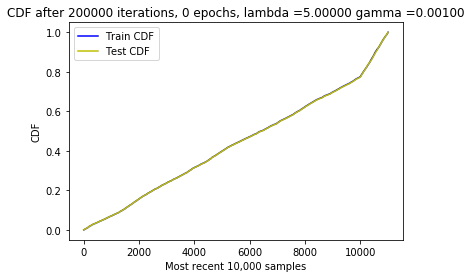

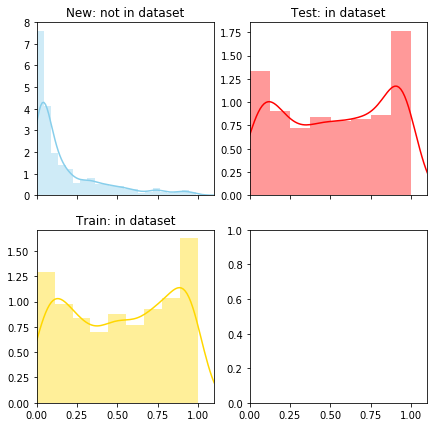

 42%|████▏     | 200004/473047 [2:38:24<587:53:34,  7.75s/it]

('New score: ', 0.19773863)
('Train score: ', 0.55163544)
('Test score: ', 0.52098066)


 63%|██████▎   | 300000/473047 [3:54:00<2:13:59, 21.52it/s]  

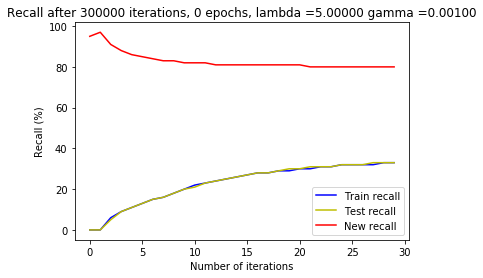

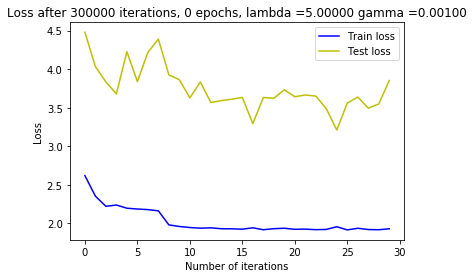

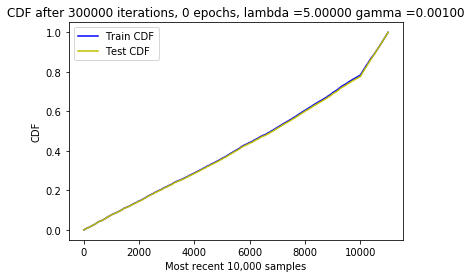

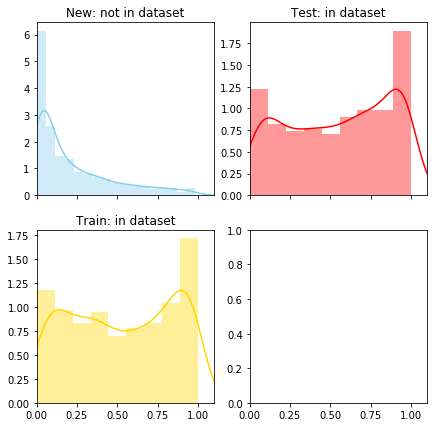

 63%|██████▎   | 300004/473047 [3:54:20<373:26:03,  7.77s/it]

('New score: ', 0.19737957)
('Train score: ', 0.5101009)
('Test score: ', 0.5585893)


 85%|████████▍ | 400000/473047 [5:13:20<56:32, 21.53it/s]    

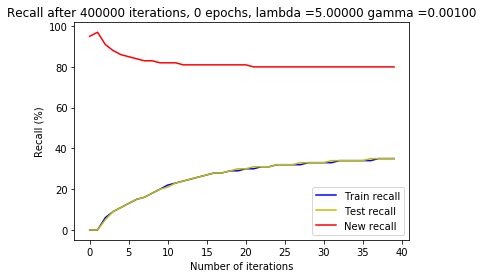

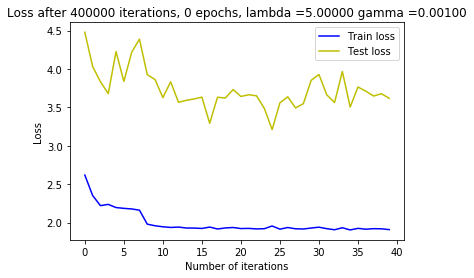

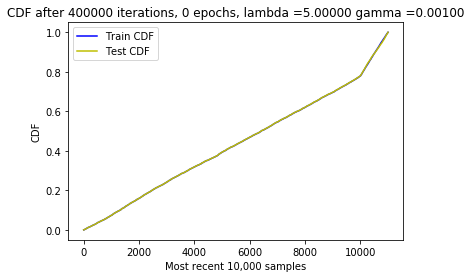

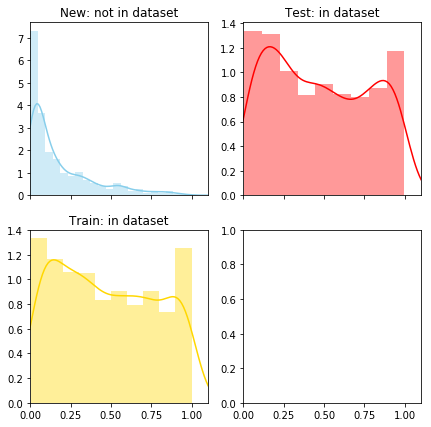

 85%|████████▍ | 400004/473047 [5:13:45<156:12:28,  7.70s/it]

('New score: ', 0.21937504)
('Train score: ', 0.41478267)
('Test score: ', 0.49492824)


 97%|█████████▋| 459999/473047 [6:02:10<10:23, 20.93it/s]    

In [ ]:
for g in gammas:
    for l in lambdas:
        print("Lambda: " + str(l) + " Gamma: " + str(g))
        model = Conv1dModelSimple()
        # Generate Loss Samples
        if 'Conv1' in model.name:
            train_loss_samples = loss_samples(k, 'train', conv_type='1d')
            test_loss_samples = loss_samples(k, 'test', conv_type='1d')
            prime_train_loss_samples = prime_loss_samples(k, 'train', conv_type='1d')
            prime_test_loss_samples = prime_loss_samples(k, 'test', conv_type='1d')
        else:
            train_loss_samples = loss_samples(k, 'train', conv_type='2d')
            test_loss_samples = loss_samples(k, 'test', conv_type='2d')
            prime_train_loss_samples = prime_loss_samples(k, 'train', conv_type='2d')
            prime_test_loss_samples = prime_loss_samples(k, 'test', conv_type='2d')
        
        model.apply(weights_init)
        model.cuda()
        sgd(model_name=model.name, gamma=g, lamb=l, save_checkpoints=True)

## Relevance of learned motifs

In [ ]:
checkpointed_model = '../models/model_checkpoints/mle_model.pth'
checkpoint = torch.load(checkpointed_model)
model = Conv1dModelSimple()
optim = SGD(model.parameters(), lr=1e-3)
model.load_state_dict(checkpoint['model_state_dict'])
optim.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
model.to(device)
print(str(epoch))

In [ ]:
print(str(len(S_prime_test)))
print(str(len(S_test)))

In [ ]:
# Validation set is S_prime_test and S_test
validation_set = []
for (apt, pep), label in S_prime_test[:118262]:
    validation_set.append((apt, pep, label))

for (apt, pep) in S_test[:4000]:
    validation_set.append((apt, pep, 0))

np.random.shuffle(validation_set)

In [ ]:
validation_set[0]

In [ ]:
correct = 0
hydrophobicity_binding = []
hydrophobicity_free = []
arginine_binding = []
arginine_free = []

for (apt, pep, label) in validation_set:
    if 'Conv1' in model.name:
        conv_type='1d'
    else:
        conv_type='2d'
    x, y = convert(apt, pep, conv_type=conv_type)
    score = model(x, y).cpu().detach().numpy().flatten()[0]
    hp = 0
    for aa in pep:
        hp += hydrophobicity[aa]
    
    if score < 0.3:
        hydrophobicity_free.append(hp)
        arginine_free.append(pep.count('R'))
    elif score > 0.6:
        hydrophobicity_binding.append(hp)
        arginine_binding.append(pep.count('R'))


In [ ]:
print("Average Hydrophobicity of binding peptides: ", np.mean(np.asarray(hydrophobicity_binding)))
print("Average Hydrophobicity of non-binding peptides: ", np.mean(np.asarray(hydrophobicity_free)))
print("Average Number of Arginines in binding peptides: ", np.mean(np.asarray(arginine_binding)))
print("Average Number of Arginines in non-binding peptides: ", np.mean(np.asarray(arginine_free)))

In [ ]:
plt.hist(hydrophobicity_binding, bins=10, label='Hydrophobicity of Binding Peptides')
plt.hist(hydrophobicity_free, bins=10 , label='Hydrophobicity of Non-Binding Peptides')
plt.ylabel("Density")
plt.xlabel("Hydrophobicity Score")
plt.title('Hydrophobicity of Test Set Outputs')
plt.legend()
plt.show()

In [ ]:
# Arginine content
plt.hist(arginine_binding, bins=8, label='Number of arginines in binding peptides')
plt.hist(arginine_free, bins=8 , label='Number of arginines in non-binding peptides')
plt.ylabel("Density")
plt.xlabel("Number of Arginines")
plt.title('Arginine Count in Peptides')
plt.legend()
plt.show()